Clusterização de dados utilizando Algoritmo Genético (codificação real, mutação gaussiana e crossover aritmético) e Kmeans

**Aluno**: Iran Freitas Ribeiro

**Matrícula**: 2021241588

**Disciplina**: Computação Natural

**Professor**: Renato Antonio Kroling

Código do GA adaptado de [Simple Genetic Algorithm](https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/) por Jason Brownlee, com algumas funções retiradas de https://github.com/dandynaufaldi/particle-swarm-optimized-clustering para adatapção da clusterização

In [1]:
import numpy as np
from numpy.lib.npyio import load
from numpy.random import randint
from numpy.random import rand
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets



def selection(pop, scores, k=3):
    """
    Realiza a selação por torneio
    """
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

def crossover(p1, p2):
    """
    Realiza o crossover aritimético
    """
    beta = np.random.uniform()
    c1 = beta*p1 + (1 - beta)*p2
    beta = np.random.uniform()
    c2 = (1 - beta)*p1 + beta*p2    
    return [c1, c2]

# mutação gaussiana
def mutation(p, r_mut, alpha):
    """
    Realiza a mutação gaussiana
    """
    pmutate = p.flatten()
    for i in range(len(pmutate)):
        if rand() < r_mut:
            pmutate[i] = np.random.normal(loc=pmutate[i], scale=alpha, size=None)
    pmutate = pmutate.reshape(p.shape)
    return pmutate

def choose_initial_centroid(data, pop, bounds, n_pop):
    """
    Busca um centróide válido qualquer da população
    """

    # escolhe o primeiro individuo com centroid valido
    for i in range(n_pop):
        init_clusters = predict(data, pop[i])
        _, best_eval = 0, eval_individual(pop[i], init_clusters, data)

        if (not np.isnan(best_eval)) and (best_eval != np.inf):
            return i, best_eval
    return 0, np.inf

def calc_distance(data, centroids):
    """
    Calcula distância entre dados e centroids
    """
    distances = []
    for c in centroids:
        distance = np.sum((data - c) * (data - c), axis=1)
        distances.append(distance)

    distances = np.array(distances)
    distances = np.transpose(distances)
    return distances

def quantization_error(centroids: np.ndarray, labels: np.ndarray, data: np.ndarray) -> float:
    error = 0.0
    for i, c in enumerate(centroids):
        idx = np.where(labels == i)[0]
        dist = np.linalg.norm(data[idx] - c, axis=1).sum()
        if (len(idx) == 0):
            dist = np.inf
        else:
            dist /= len(idx)
        error += dist
    error /= len(centroids)
    return error
            
def eval_individual(centroids, predict_data, data):
    """
    Avalia um indivíduo da população
    """
    score = quantization_error(centroids, predict_data, data)
    return score

def predict(data, centroids):
    """
    Retorna os clusters para cada ponto dos dados
    """
    distance = calc_distance(data, centroids)
    cluster = assign_cluster(distance)
    return cluster

def assign_cluster(distance):
    """
    Atribui um cluster para cada distância calculada
    """
    cluster = np.argmin(distance, axis=1)
    return cluster

def genetic_algorithm(n_clusters, bounds, n_bits, n_iter, n_pop, r_mut, alpha, data, r_decr):
    """
    Algoritmo Genético
    """
    # inicia a população com valores reais entre [bounds[0], bounds[1]]
    # Cada indivíduo da população representa um centroid
    pop = [np.random.uniform(bounds[0], bounds[1], size=n_clusters*data.shape[1]) for _ in range(n_pop)]
    # transforma cada individuo no formato esperado para o cluster (matriz com 3*4 dimensões)
    pop = [p.reshape(n_clusters,data.shape[1]) for p in pop]
    best, best_eval = choose_initial_centroid(data, pop, bounds, n_pop)
    # enumerate generations
    hist_best_eval = [best_eval]
    kscore = np.inf
    popibest = 0
    for gen in range(n_iter):
        # decode population
        clusters = [predict(data, p) for p in pop]
        # evaluate all candidates in the population
        scores = [eval_individual(p, pc, data) for p, pc in zip(pop, clusters)]
        # check for new best solution
        
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                popibest = i
                
        ## Aplicando o kmeans para acelerar o processo de clusterização
        if (kscore != np.inf):
            init_centroid  = best
        
        kmeans = KMeans(n_clusters=n_clusters, init=best, n_init=1)
        kmeans.fit(data)
        kmeans_clusters = kmeans.predict(data)
        # avalia o kmeans
        kscore = eval_individual(kmeans.cluster_centers_, kmeans_clusters, data)
        # atualizar o valor do melhor score
        if kscore <= best_eval:
            best = kmeans.cluster_centers_
            best_eval = kscore
            # atualiza melhor individuo da população pelo kmeans
            pop[popibest] = best
        else:
            kscore = np.inf
        
        if (gen%10 == 0):
            if (kscore == np.inf):
                print ("Best> gen:{} individuo: {} score: {:.5f}".format(gen, popibest, best_eval))
            else:
                print ("Best> (from kmeans) gen: {} score: {:.5}".format(gen, best_eval))
        # select parents
        hist_best_eval.append(best_eval)
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation    
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2):
                # mutation
                c = mutation(c, r_mut, alpha)
                # store for next generation
                children.append(c)
        alpha -= r_decr
        # replace population
        pop = children
    return [best, best_eval, hist_best_eval]

### Experimentos

10 execuções do algorítimo genético com os parâmetros:

- Tamanho da população: 100
- Taxa de mutação: ~0.09
- $\alpha$: Inicia com 0.5 e descresce gradualmente ao longo das gerações

**Carrega o dataset**

In [2]:
data_iris = datasets.load_iris(as_frame=True)
iris_names = data_iris.target_names
data = data_iris.data
X = data.iloc[:, [0, 1, 2, 3]].values

In [6]:
bounds = [0.1, 7.9]
### remover
pop = [np.random.uniform(bounds[0], bounds[1], size=3*X.shape[1]) for _ in range(1)]
    # transforma cada individuo no formato esperado para o cluster (matriz com 3*4 dimensões)
pop = [p.reshape(3,X.shape[1]) for p in pop]

In [11]:
predict(X, pop[:1])

ValueError: operands could not be broadcast together with shapes (150,4) (3,4) 

In [20]:
bounds = [0.1, 7.9]
#numero de clusters
n_clusters = 3
# define the total iterations
#n_iter = 200
n_iter = 200
# bits per variable
n_bits = 32
# define the population size
n_pop = 100
# mutation rate
r_mut = 0.09
# alpha utilizado na mutação gaussiana
alpha = 0.5
r_decr = alpha/n_iter

best, score, hist_scores  = genetic_algorithm(n_clusters, bounds, n_bits, n_iter,
                            n_pop, r_mut, alpha, X, r_decr)

Best> (from kmeans) gen: 0 score: 0.64657
Best> (from kmeans) gen: 10 score: 0.64657
Best> gen:20 individuo: 94 score: 0.64610
Best> gen:30 individuo: 94 score: 0.64610
Best> gen:40 individuo: 63 score: 0.64542
Best> gen:50 individuo: 5 score: 0.64474
Best> gen:60 individuo: 59 score: 0.64347
Best> gen:70 individuo: 96 score: 0.64222
Best> gen:80 individuo: 96 score: 0.64222
Best> gen:90 individuo: 96 score: 0.64222
Best> gen:100 individuo: 89 score: 0.64219
Best> gen:110 individuo: 44 score: 0.64202
Best> gen:120 individuo: 45 score: 0.64201
Best> gen:130 individuo: 45 score: 0.64201
Best> gen:140 individuo: 45 score: 0.64201
Best> gen:150 individuo: 45 score: 0.64201
Best> gen:160 individuo: 3 score: 0.64191
Best> gen:170 individuo: 38 score: 0.64190
Best> gen:180 individuo: 96 score: 0.64186
Best> gen:190 individuo: 1 score: 0.64181


# Visualização da clusterização

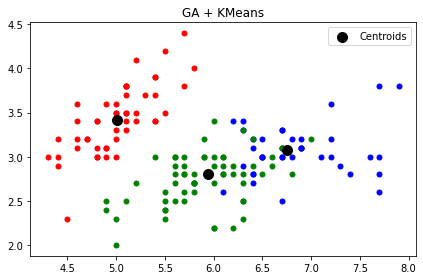

In [23]:
# Pega os clusters
y_kmeans = predict(X, best)
fig, ax = plt.subplots()
ax.set_title("GA + KMeans")
# clusters
ax.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='red', marker='.')
ax.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', marker='.')
ax.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', marker='.')

# centroids
ax.scatter(best[:, 0], best[:, 1], s=100, c='black', label='Centroids')
plt.legend()
plt.tight_layout()
plt.show()

# Evolução do score do Algoritmo

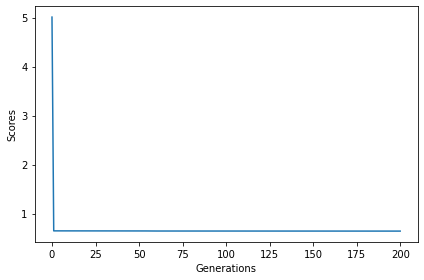

In [24]:
fig, ax = plt.subplots()
xgen = np.arange(0,n_iter+1,1)
ax.plot(xgen[0:], hist_scores[0:])
ax.set_xlabel("Generations")
ax.set_ylabel("Scores")
plt.tight_layout()
plt.show()

**Para facilitar a visualização, a figura acima é plotada a partir da geração 50**

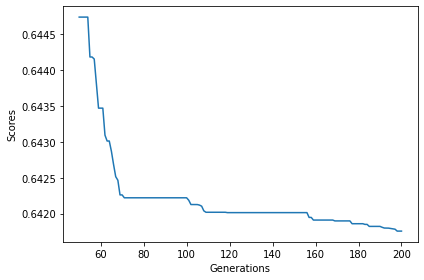

In [21]:
fig, ax = plt.subplots()
xgen = np.arange(0,n_iter+1,1)
ax.plot(xgen[50:], hist_scores[50:])
ax.set_xlabel("Generations")
ax.set_ylabel("Scores")
plt.tight_layout()
plt.show()